In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("ggplot")

# 0.Data Load
---

In [2]:
df_pdde = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv", low_memory=False)
df_copu = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_03_COP_U.csv")
df_lpay = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_06_LPAY.csv")

In [3]:
df_pdde.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1


In [4]:
df_copu.head()

,cust,rct_no,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am
0,M839993508,21102612B015763935,B01,B010012,1,20211026,20211026,12,60000
1,M839993508,21110610B014219744,B01,B010012,1,20211106,20211106,10,17100
2,M839993508,21021112B013419710,B01,B010012,1,20210211,20210211,12,136500
3,M839993508,21092010B012637545,B01,B010012,1,20210920,20210920,10,34200
4,M839993508,21101009D015920171,D01,D010614,1,20211010,20211010,9,2500


In [5]:
df_lpay.head()

,cust,rct_no,cop_c,chnl_dv,de_dt,de_hr,buy_am
0,M629656521,210803210311226,A03,1,20210803,21,10900
1,M216016456,210803130167542,L01,2,20210803,13,6860
2,M205142844,210803140275112,A02,1,20210803,14,9000
3,M737010483,210803040637594,A06,2,20210803,4,36740
4,M707775545,210803140675502,A06,2,20210803,14,138500


In [6]:
print(f"PDDE\t{len(df_pdde)}")
print(f"COPU\t{len(df_copu)}")
print(f"LPAY\t{len(df_lpay)}")

PDDE	4381743
COPU	248304
LPAY	353184


- `PDDE`와 `COP_U` 경우 유통사 제품 구매와, 제휴사 서비스 이용 내역이기 때문에 독립적인 테이블임
- `LPAY`는 엘페이를 이용한 일종의 결제 내역이기 때문에 `PDDE`와 `COP_U` 테이블과의 연관성이 있을 것으로 보임
- 따라서 확인 해야할 사항은 다음과 같음
    1. `PDDE`-`LPAY`
    2. `COP_U`-`LPAY`
- 추가적으로 통일되어 있지 않은 영수증 번호에 대한 고찰도 수행

# 1.Transaction Data 간 관계 파악
---

## 1.1. `PDDE` - `LPAY` (RAW DATAS)
---

In [7]:
df_lpay["rct_no"]=df_lpay["rct_no"].astype("str")

In [8]:
# -- 품목을 알아보기 위해 코드와 이름을 연계
df_pd = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")
df_pd.head()

,pd_c,pd_nm,clac_hlv_nm,clac_mcls_nm
0,PD0001,소파,가구,거실가구
1,PD0002,스툴/리빙의자,가구,거실가구
2,PD0003,탁자,가구,거실가구
3,PD0004,장식장/진열장,가구,거실가구
4,PD0005,기타가구,가구,기타가구


In [9]:
# -- 상품 코드와 이름을 merge
df_pdmr = df_pdde.merge(df_pd[["pd_c","pd_nm"]], on="pd_c", how="left")
df_pdmr

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1,기타주방일회용품
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠
...,...,...,...,...,...,...,...,...,...,...,...
4381738,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,백화점/마트모바일상품권
4381739,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,백화점/마트모바일상품권
4381740,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,백화점/마트모바일상품권
4381741,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,백화점/마트모바일상품권


In [10]:
# -- 중복 레코드 수
len(df_pdmr.loc[df_pdmr.duplicated()]["pd_nm"].unique().tolist())

1465

In [11]:
temp=pd.merge(left=df_pdmr, right=df_lpay, on=["cust","chnl_dv","cop_c","de_dt","de_hr","buy_am"], how="left")

In [12]:
temp

,cust,rct_no_x,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,rct_no_y
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,NaN
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1,기타주방일회용품,NaN
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,NaN
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,NaN
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4382534,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,백화점/마트모바일상품권,NaN
4382535,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,백화점/마트모바일상품권,NaN
4382536,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,백화점/마트모바일상품권,NaN
4382537,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,백화점/마트모바일상품권,NaN


In [13]:
temp.loc[~temp["rct_no_y"].isna()]

,cust,rct_no_x,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,rct_no_y
24,M686795542,A01000022861,1,A01,A010045,PD0952,20210101,11,34800.0,1,여성베스트,210101110137006
46,M511106441,A01000034639,1,A01,A010024,PD0777,20210101,12,59100.0,1,남성런닝/트레이닝화,210101120141530
68,M511106441,A01000047099,1,A01,A010024,PD0777,20210101,13,50400.0,1,남성런닝/트레이닝화,210101130143937
79,M049345995,A01000057303,1,A01,A010043,PD1827,20210101,13,39900.0,2,기타패션잡화,210101130144874
114,M502480776,A01000087195,1,A01,A010045,PD1692,20210101,14,5500.0,1,커피/음료,210101140148885
...,...,...,...,...,...,...,...,...,...,...,...,...
4382429,M324896636,E06052060518,2,A06,NaN,PD0507,20211229,16,50000.0,1,백화점/마트모바일상품권,211229160663040
4382430,M305766997,E06052061811,2,A06,NaN,PD0511,20211229,16,9800.0,1,식음료모바일상품권,211229160665309
4382431,M305766997,E06052061811,2,A06,NaN,PD0511,20211229,16,9800.0,1,식음료모바일상품권,211229160665356
4382432,M305766997,E06052062286,2,A06,NaN,PD0511,20211229,16,9800.0,1,식음료모바일상품권,211229160665309


## 1.2. `PDDE`-`LPAY` (Grouping)
---

In [39]:
df_pdg = df_pdmr.groupby(by=["rct_no","cust","de_dt","de_hr","chnl_dv","cop_c"], as_index=False)[["buy_am","buy_ct"]].sum()
df_pdg.sort_values(by="buy_ct", ascending=False)

,rct_no,cust,de_dt,de_hr,chnl_dv,cop_c,buy_am,buy_ct
1077313,A04042244825,M232228166,20210526,16,1,A04,330100.0,266
1075945,A04040876792,M290734691,20210522,16,1,A04,504450.0,204
779724,A02282909634,M112137856,20211117,22,1,A02,45100.0,189
520046,A02017913369,M412288994,20210126,18,1,A02,3117100.0,169
531203,A02029319956,M412288994,20210829,17,1,A02,2779400.0,156
...,...,...,...,...,...,...,...,...
203727,A01203944567,M754014828,20210531,10,1,A01,213000.0,1
203726,A01203943299,M629919642,20210531,10,1,A01,8200.0,1
203725,A01203942146,M318204051,20210531,10,1,A01,10500.0,1
203724,A01203941101,M318204051,20210531,10,1,A01,33000.0,1


In [45]:
# -- 유통사에서 LPAY를 이용하여 구매한 내역
df_pdlp = pd.merge(left=df_pdg, right=df_lpay, on=["cust","de_dt","de_hr","buy_am","cop_c","chnl_dv"], how="left")
df_pdlp.loc[~df_pdlp["rct_no_y"].isna()]
# df_pdlp

,rct_no_x,cust,de_dt,de_hr,chnl_dv,cop_c,buy_am,buy_ct,rct_no_y
21,A01000022861,M686795542,20210101,11,1,A01,34800.0,1,210101110137006
33,A01000034639,M511106441,20210101,12,1,A01,59100.0,1,210101120141530
46,A01000047099,M511106441,20210101,13,1,A01,50400.0,1,210101130143937
56,A01000057303,M049345995,20210101,13,1,A01,39900.0,2,210101130144874
86,A01000087195,M502480776,20210101,14,1,A01,5500.0,1,210101140148885
...,...,...,...,...,...,...,...,...,...
1267330,E06052060518,M324896636,20211229,16,2,A06,50000.0,1,211229160663040
1267331,E06052061811,M305766997,20211229,16,2,A06,9800.0,1,211229160665309
1267332,E06052061811,M305766997,20211229,16,2,A06,9800.0,1,211229160665356
1267333,E06052062286,M305766997,20211229,16,2,A06,9800.0,1,211229160665309


- 결제 내역 or 결제 수단에 대해서는 `rct_no`로 group화 해서 결합
- 고객 개인화 전략에 대해서는 품목에 포커스를 두는게 좋음 (품목 누락 없이)

## 1.3.`COP_U`-`LPAY` (Grouping)
---

In [46]:
# -- 유통사에서 LPAY를 이용하여 구매한 내역
df_colp = pd.merge(left=df_copu, right=df_lpay, on=["cust","de_dt","de_hr","buy_am","cop_c","chnl_dv"], how="left")
df_colp.loc[~df_colp["rct_no_y"].isna()]

,cust,rct_no_x,cop_c,br_c,chnl_dv,de_dt,vst_dt,de_hr,buy_am,rct_no_y
149,M819061016,21061414C012814154,C01,C010030,2,20210614,20210614,14,10000,210614140170019
150,M819061016,21030807C014918101,C01,C010030,2,20210308,20210308,7,10000,210308070107534
152,M819061016,21091213C013717403,C01,C010030,2,20210912,20210913,13,14000,210912130134399
153,M819061016,21040610C010718712,C01,C010030,2,20210406,20210406,10,10000,210406100128607
154,M819061016,21041212C011112960,C01,C010030,2,20210412,20210412,12,10000,210412120151125
...,...,...,...,...,...,...,...,...,...,...
248550,M212153484,21110808D012335749,D01,D011124,1,20211108,20211108,8,3700,211108080117490
248551,M212153484,21112208D010240560,D01,D011124,1,20211122,20211122,8,4900,211122080158767
248552,M212153484,21120709D012342001,D01,D011124,1,20211207,20211207,9,4100,211207090181291
248553,M212153484,21091508D010452308,D01,D011124,1,20210915,20210915,8,5900,210915080169814


In [47]:
pdde_rct = df_pdlp.loc[~df_pdlp["rct_no_y"].isna()]["rct_no_y"].values.tolist()
copu_rct = df_colp.loc[~df_colp["rct_no_y"].isna()]["rct_no_y"].values.tolist()

In [49]:
df_lpay.loc[df_lpay["rct_no"].isin(pdde_rct+copu_rct)]

,cust,rct_no,cop_c,chnl_dv,de_dt,de_hr,buy_am
0,M629656521,210803210311226,A03,1,20210803,21,10900
2,M205142844,210803140275112,A02,1,20210803,14,9000
6,M253450307,210803160182662,C01,2,20210803,16,1000
7,M186539937,210803130266856,D02,1,20210803,13,9600
8,M347475637,210803160182823,C01,2,20210803,16,1000
...,...,...,...,...,...,...,...
353169,M688241278,210129180288509,A02,1,20210129,18,6400
353170,M688241278,210122180255723,A02,1,20210122,18,7520
353171,M688241278,210123150218189,A02,1,20210123,15,5460
353175,M484453427,210131160335899,A03,1,20210131,16,9900


In [51]:
temp = df_lpay.loc[~df_lpay["rct_no"].isin(pdde_rct+copu_rct)]
temp["cop_c"].value_counts()

A06    92311
L01    70939
A01    23924
A04    23709
A02    23515
L00    22526
A03    12710
D01     7695
A05     2239
C01     1275
C02      645
E01      472
D02      374
B01      249
Name: cop_c, dtype: int64

1. LPAY O / LPAY X 어떻게 구분할 것인가? -> 완벽히 구분한다? 주제 설정이 수월
2. PDDE - 중복이 무엇인가?
3. LPAY가 연결 안 되는 데이터는 무엇인가?

<span style="color:red">**주최 측 문의 내역 일부**</span>

- `PDDE`/`COP_U`/`LPAY`는 무작위 추출에 의해 선정된 데이터이므로 연관된 내역이 아님
- 관련 내역 발최
    > **첫번째 질문입니다.**
    >>만약 엘페이로 상품구매(제휴사이용) 결제할 때, 상품구매(제휴사 이용)에서의 buy_am은 엘페이에서의 buy_am과 동일한가요? 처음에는 buy_am을 제외한 속성을 가지고 두 테이블(상품구매-엘페이, 제휴사이용-엘페이)의 중복 데이터를 찾고자 했고, 엘페이의 금액이 작은 경우는 일부만 엘페이로 결제한 결과라고 생각했습니다. QnA를 살펴보니, 비복원 추출에 의해서 엘페이 결제 영수증 한 건이 상품구매 테이블에 없을 수도 있기 때문에, 가격이 다른 경우 아예 다른 결제 상황일 가능성이 높다고 생각했습니다.<br><br>엘페이로 상품 구매할 때, 엘페이의 buy_am이 상품금액 buy_am에 그대로 반영이 되는 것인지. 아니면 상품 구매 buy_am과 엘페이 buy_am이 다를 수도 있는 것인지 궁금합니다.

    >**두번째 질문입니다.**
    >>상품구매 테이블에서 구매한 금액은 결제 금액을 뜻하나요? 상품 금액을 뜻하나요? buy_cnt가 2일 경우, buy_am이 100이라면, 영수증 한 건에서 결제한 금액이 100원인지, 200원인지 궁금합니다.

    >**답변**
    >>**첫번째 질문**<br>→ 동일하지 않습니다. 두 거래 테이블이 완전히 일치하는 데이터가 아니며 거래 건 또는 금액이 일치하지 않을 수 있습니다.<br><br>
    >>**두번째 질문**<br>→ 결제 금액을 의미합니다. cnt가 2건인 경우 2개 상품의 합산 금액이므로 말씀하신 buy_cnt가 2일 경우, buy_am이 100라면 상품의 가격은 50원이며 결제 금액은 100원입니다.
- 추가적으로 [FAQ](https://aifactory.space/notice/detail/67) 확인 必

# 2.LPAY 중심 데이터 처리
---

In [26]:
df_lpd = df_lpay.loc[df_lpay["cop_c"].str.contains("A")]
df_lcp = df_lpay.loc[~df_lpay["cop_c"].str.contains("A")&~df_lpay["cop_c"].str.contains("L")]
df_ncp = df_lpay.loc[df_lpay["cop_c"].str.contains("L")]

In [27]:
df_lpd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227997 entries, 0 to 353182
Data columns (total 7 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   cust     227997 non-null  object
 1   rct_no   227997 non-null  object
 2   cop_c    227997 non-null  object
 3   chnl_dv  227997 non-null  int64 
 4   de_dt    227997 non-null  int64 
 5   de_hr    227997 non-null  int64 
 6   buy_am   227997 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 13.9+ MB


In [28]:
df_lcp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31722 entries, 6 to 353183
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cust     31722 non-null  object
 1   rct_no   31722 non-null  object
 2   cop_c    31722 non-null  object
 3   chnl_dv  31722 non-null  int64 
 4   de_dt    31722 non-null  int64 
 5   de_hr    31722 non-null  int64 
 6   buy_am   31722 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.9+ MB


In [29]:
df_ncp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93465 entries, 1 to 353174
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   cust     93465 non-null  object
 1   rct_no   93465 non-null  object
 2   cop_c    93465 non-null  object
 3   chnl_dv  93465 non-null  int64 
 4   de_dt    93465 non-null  int64 
 5   de_hr    93465 non-null  int64 
 6   buy_am   93465 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 5.7+ MB


In [30]:
for df in [df_lpd, df_lcp, df_ncp]:
    print(df["cop_c"].unique())
    print()

['A03' 'A02' 'A06' 'A01' 'A04' 'A05']

['C01' 'D02' 'D01' 'C02' 'E01' 'B01']

['L01' 'L00']



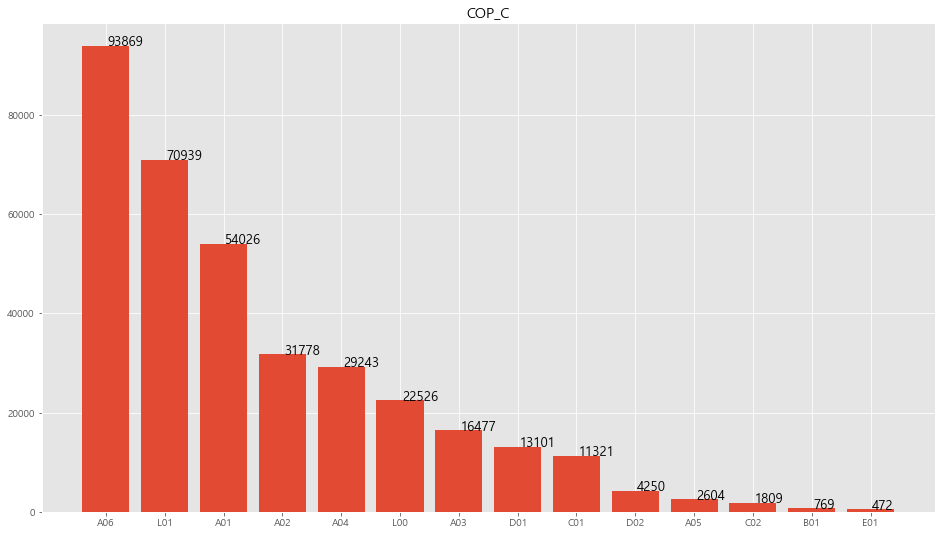

In [34]:
# pie chart
plt.bar(df_lpay["cop_c"].value_counts().index,
        df_lpay["cop_c"].value_counts().values)
x = .03
for val in df_lpay["cop_c"].value_counts().tolist():
        plt.text(x=x, y=val, s=str(val), size=13)
        x+=1
plt.title("COP_C")
plt.show()